## Classification de pièces d'ordinateurs en utilisant un réseau neuronal convolutif (CNN)

Le but de ce code est de mettre en oeuvre un CNN à l'aide de tensorflow/keras qui permette de faire de la classification sur une base de donnée d'images de pièces d'ordinateurs.

Nous allons utiliser une base de données publiée sur [kaggle.com](https://www.kaggle.com/datasets/asaniczka/pc-parts-images-dataset-classification) qui contient ~3200 images de composants d'ordinateurs classés en 14 catégories. Les images ont été modifiées pour avoir une taille de 256 pixels. Nous téléchargerons directement les données depuis kaggle.

### préparation
nous allons utiliser les librairies tensorflow et keras pour créer notre réseau neuronal. Nous aurons également besoin de kagglehub pour télécharger la base de donnée

In [1]:
pip install tensorflow[and-cuda] matplotlib kagglehub seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Chargement des librairies nécessaires

In [176]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub

tf.get_logger().setLevel('ERROR')

In [177]:
# We download latest dataset version directly from kaggle
# The dataset size is around 35MB
path = kagglehub.dataset_download("asaniczka/pc-parts-images-dataset-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/sagon/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1


Nous chargeons les données dans keras. Nous divisons le dataset en deux parties, l'une pour l'entraînement et l'autre pour la validation. Nous forçons les images à une taille de 256 x 256 pixels, ce qui est déjà leur taille.

In [204]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    directory = path+'/pc_parts',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    shuffle=True,
    seed=123, # we use a seed to warant reproductible results
    image_size=(256, 256),
    validation_split=0.2, # we reserv 20% of data for validation
    subset='both' # we return a tuple of train and test
)

print(train_ds)
print(test_ds)

Found 3279 files belonging to 14 classes.
Using 2624 files for training.
Using 655 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Nous avons chargé nos données. Nous devons normaliser chaque pixel à une valeur entre 0 et 1 en float.

In [205]:
normalized_train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
normalized_test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

Le nom des catégories sont inférées directement selon les répertoirs où ils se trouvent. Voilà leurs noms.

In [206]:
class_names = train_ds.class_names
print(class_names)

['cables', 'case', 'cpu', 'gpu', 'hdd', 'headset', 'keyboard', 'microphone', 'monitor', 'motherboard', 'mouse', 'ram', 'speakers', 'webcam']


# validation du dataset
Nous commençons par afficher les 25 premières images avec leur catégorie respective pour effectuer un contrôle rapide de la qualité des données. Les images sont fournies de manière aléatoires.

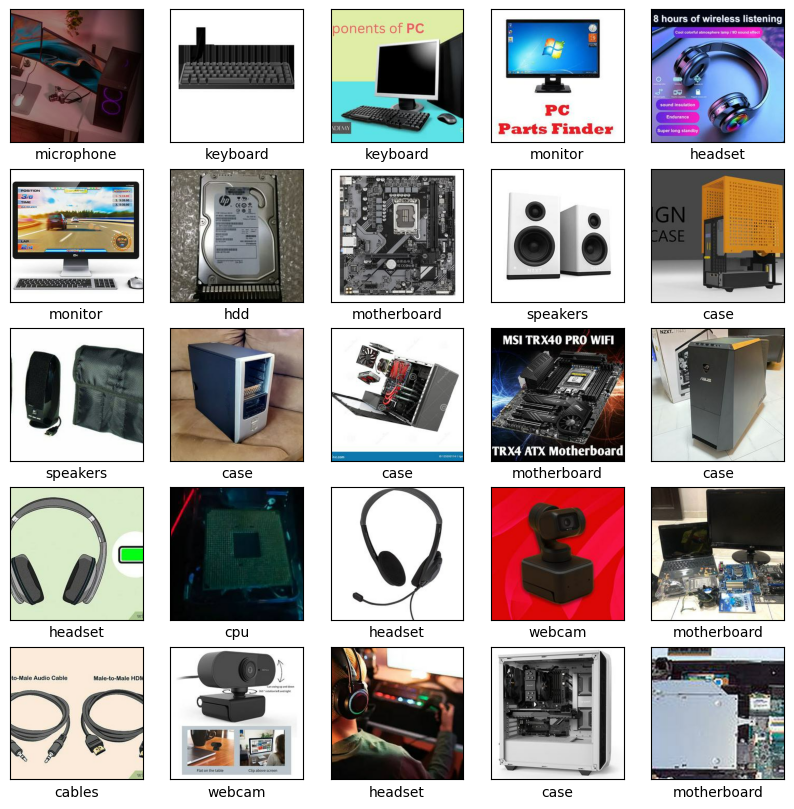

In [207]:
count = 0

plt.figure(figsize=(10,10))

for images, labels in normalized_train_ds: # this returns a batch
    for i in range(len(images)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
        count += 1
        if count == 25: 
            break
    if count == 25:
        break
plt.show()

## Vérification de la distribution des données par classes

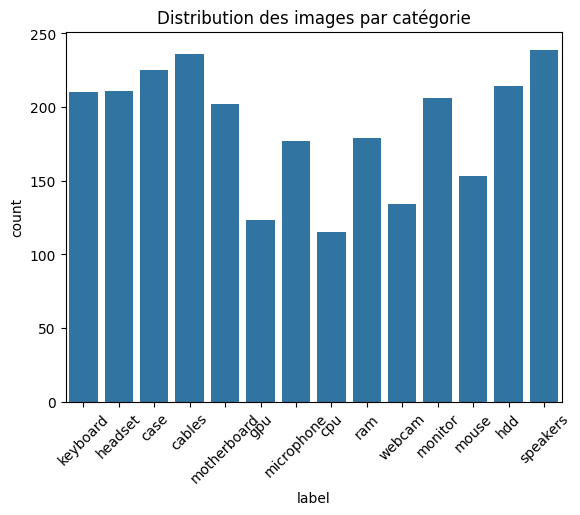

In [208]:
# extract labels and convert them to a numpy array
labels = np.concatenate([y for x, y in train_ds], axis=0)

# create a DataFrame with the labels and the class name
label_names = [class_names[label] for label in labels]
df = pd.DataFrame({'label': label_names})

# Display label distribution
sns.countplot(x='label', data=df)
plt.title("Distribution des images par catégorie")
plt.xticks(rotation=45)
plt.show()

La distribution n'est pas très bien balancée. Nous ne vérifions pas la taille des images, elles ont été chargées avec une taille fixe.

In [209]:
counts = df['label'].value_counts()

# Identify the most respresented class
max_count = max(counts)

# Compute the missing category per class
missing_images = {}
for k,v in counts.items():
    if v < max_count:
        missing_images[k] = max_count - v

print(f"Missing images per category: {missing_images}")


Missing images per category: {'cables': 3, 'case': 14, 'hdd': 25, 'headset': 28, 'keyboard': 29, 'monitor': 33, 'motherboard': 37, 'ram': 60, 'microphone': 62, 'mouse': 86, 'webcam': 105, 'gpu': 116, 'cpu': 124}


# Data augmentation
Nous allons dériver certaines images pour en créer des "nouvelles" dans le but d'éviter le suraprentissage. Pour cela nous le faisons directement avec les layers de keras. Voilà un test avec affichage de l'image original et de la version modifiée

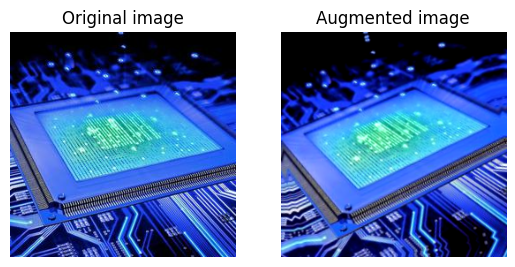

In [210]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# We define the layers to be applied to the image
data_augmentation = models.Sequential([
    RandomZoom(.1),
    RandomRotation(.1),
    RandomContrast(.4)
])

# we create one augmented image as test
count = 0
for images, labels in normalized_train_ds: # this returns a batch
    count
    for i in range(len(images)):
        sample_image = tf.image.convert_image_dtype(images[i], dtype=tf.float32)
        augmented_image = data_augmentation(tf.expand_dims(sample_image, axis=0))
        count += 1
        if count == 1: 
            break
    if  count == 1:
        break

# the images must be cliped as they have values bigger than 1.0
scaled_image = tf.clip_by_value(augmented_image, 0.0, 1.0)

# Disply original image
plt.subplot(1, 2, 1)  # (n_rows, n_columns, index)
plt.imshow(sample_image.numpy())
plt.axis("off")  # Supprimer les axes
plt.title("Original image")

# Display augmented image
plt.subplot(1, 2, 2)
plt.imshow(scaled_image[0].numpy())
plt.axis("off")
plt.title("Augmented image")

plt.show()

# Création du model séquentiel avec les différentes couches cachées

In [211]:
augmentation = True

model = models.Sequential()
model.add(keras.Input(shape=(256,256,3))) # first we define the input shape
if augmentation:
    model.add(data_augmentation) # the augmentation layer
    #model.add(data_augmentation) # we can add a second time the augmentation layer to have another image
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [212]:
model.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_64 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

# Ajout des couches denses pour la sortie et mise à plat des paramètres

In [213]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14)) #nb classes

In [214]:
model.summary()

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_64 (Sequential)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │    14,745,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,802,894 (56.47 MB)

 Trainable params: 14,802,894 (56.47 MB)

 Non-trainable params: 0 (0.00 B)

# Compilation du modèle et entrainement
Le dataset est traité par lot de 32 images

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(normalized_train_ds, epochs=100, validation_data=normalized_test_ds)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.0765 - loss: 3.0828 - val_accuracy: 0.0931 - val_loss: 2.6195
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.1092 - loss: 2.6017 - val_accuracy: 0.1344 - val_loss: 2.5462
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.1522 - loss: 2.5418 - val_accuracy: 0.1542 - val_loss: 2.5092
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.1872 - loss: 2.4729 - val_accuracy: 0.2092 - val_loss: 2.3961
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.2318 - loss: 2.3086 - val_accuracy: 0.2137 - val_loss: 2.3993
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2617 - loss: 2.2526 - val_accuracy: 0.2733 - val_loss: 2.3125
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2998 - loss: 2.1371 - val_accuracy: 0.2916 - val_loss: 2.2826
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.3496 - loss: 2.0380 - val_accuracy: 0.

# Evaluation du modèle

Nous comparons l'accuracy en fonction des Epoch. On veut minimiser la fonction de coût, qui est la mesure l'écart entre la prédiction et la valeur réelles. Pour ceci on ajuste les paramètres pour le rendre plus précis. Accuracy est la valeur sur le dataset d'apprentissage et val_accuracy sur le dataset de test.

21/21 - 0s - 24ms/step - accuracy: 0.3618 - loss: 5.2098


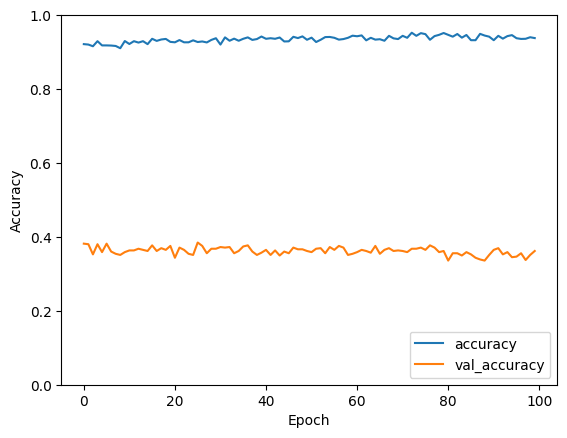

In [199]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(normalized_test_ds, verbose=2)

# Sauvegarde et Chargement du model
## Sauvegarde
Il est possible de sauvegarder le model entrainé pour continuer l'entrainement plus tard (checkpoint) our faire de l'inférence. Attention, la taille sur disque est non négligeable (170M dans ce cas)

In [191]:
model.save('mon_modele.keras') 

## Lecture du model pour utilisation

In [192]:
model = load_model('mon_modele.keras')

# Utilisation du model (inférence)

In [200]:
for images, labels in normalized_test_ds.take(1):
    my_images = images
    my_labels = labels

Nous effectuons la prédiction. Le modele retourne un tableau NumPy avec les prédictions.

In [201]:
prediction = model.predict(my_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Nous comparons le résultat avec la référence.

In [202]:
predicted_class = np.argmax(prediction, axis=-1)
count = 0
wrong = ''

for i in predicted_class:
    if i != my_labels[count]:
        wrong ="<! wrong !> "
    print(f"{wrong}Classe prédite : {class_names[i]}. Classe réelle {class_names[my_labels[count]]}")
    count+=1
    wrong = ''


<! wrong !> Classe prédite : headset. Classe réelle speakers
<! wrong !> Classe prédite : cables. Classe réelle gpu
Classe prédite : webcam. Classe réelle webcam
Classe prédite : monitor. Classe réelle monitor
<! wrong !> Classe prédite : motherboard. Classe réelle gpu
<! wrong !> Classe prédite : monitor. Classe réelle speakers
Classe prédite : case. Classe réelle case
<! wrong !> Classe prédite : motherboard. Classe réelle cpu
<! wrong !> Classe prédite : mouse. Classe réelle webcam
<! wrong !> Classe prédite : webcam. Classe réelle mouse
<! wrong !> Classe prédite : mouse. Classe réelle speakers
<! wrong !> Classe prédite : cables. Classe réelle microphone
Classe prédite : motherboard. Classe réelle motherboard
<! wrong !> Classe prédite : monitor. Classe réelle microphone
<! wrong !> Classe prédite : motherboard. Classe réelle gpu
<! wrong !> Classe prédite : keyboard. Classe réelle headset
<! wrong !> Classe prédite : hdd. Classe réelle microphone
<! wrong !> Classe prédite : head

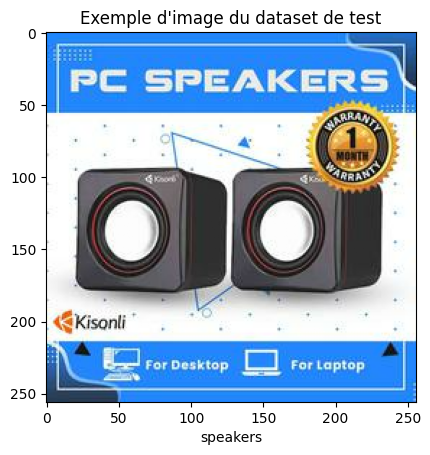

In [203]:
plt.title("Exemple d'image du dataset de test")
plt.xlabel(class_names[my_labels[0]])
plt.imshow(my_images[0])

# Conclusion
Le résultat n'est pas très bon. J'ai tenté d'augmenter le nombre d'epoch, le résultat n'est pas meilleur et il y a un problème de sur apprentissage. On voit bien dans le graph d'accuracy que même avec moins d'epoch nous aurions le même résultat.

Une des raisons de ce mauvais résultat peut-être lié à la relative petite taille du dataset et du nombre important de catégories et de certaines images trop loin de la réalité de la catégorie. Pour éviter problème de surapprentissage, j'ai ajouté des couches de modification aléatoire des images directement dans le model. Après avoir relancé l'apprentissage, val_accuracy est passé de 0.2 à 0.3. En augmentant le nombre d'epoch à 100 val_accuracy passe à presque 0.4

Initialement, j'avais un ratio de 10% entre les dataset d'apprentissage et de test. En passant à 20%, l'accuracy a augmenté également.

Ce qu'il peut-être fait pour augmenter la performance est de créer des images dérivées des existantes pour équilibrer le nombre d'image par catégorie. Egalement il faudrait supprimer certaines images non representative.